In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette(sns.color_palette('Set2')[::2])
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs

figure_dir = "fig/tokenization"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [2]:
exps = pd.read_table("../dataframes/all_char_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])
exps1 = add_probing_location_better_column(exps)

In [3]:
exps = pd.read_table("../dataframes/all_lc_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])
exps["probing_location_better"] = True
exps2 = exps

In [4]:
exps = pd.concat([exps1, exps2], ignore_index=True)
exps.perturbation.unique()

array([nan, 'mBERT-char', 'mBERT-rand-char', 'mBERT-rand-subw',
       'mBERT-lc-3', 'mBERT-rand-lc-1', 'mBERT-lc-1', 'mBERT-lc-2',
       'mBERT-rand-lc-2', 'mBERT-rand-lc-3'], dtype=object)

## Load fertility and majority baseline

In [5]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
fertility.shape

(319, 14)

In [6]:
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Model perturbations

In [7]:
model_perturbations = [
    'mBERT-char',
    'mBERT-lc-1',
    'mBERT-lc-2',
    'mBERT-lc-3',
    'mBERT-rand-subw', 
    'mBERT-rand-char',
    'mBERT-rand-lc-1',
    'mBERT-rand-lc-2',
    'mBERT-rand-lc-3',
]

models = ['mBERT'] + model_perturbations

baselines = exps[
    ((exps.model=='mBERT') & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isin(model_perturbations)))
]
baselines = baselines[baselines['probing_location_better']==True].copy()
baselines

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,majority_baseline,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
3,mBERT,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
5,mBERT,Afrikaans,number_noun,mBERT-rand-char,last,88.00,85.15,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
7,mBERT,Afrikaans,number_noun,mBERT-rand-subw,last,81.10,83.80,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
8,mBERT,Afrikaans,number_noun,mBERT-lc-3,last,92.25,91.50,number,noun,Afrikaans number_noun,...,50.0,127.41375,3.001271,1.731115,42.552500,24.79375,10.723333,3.508751,3.307917,8.491142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,mBERT,Urdu,number_noun,mBERT-rand-lc-1,last,89.50,82.95,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
4462,mBERT,Urdu,number_noun,mBERT-lc-1,last,94.25,88.85,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
4463,mBERT,Urdu,number_noun,mBERT-lc-2,last,95.75,87.15,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958
4464,mBERT,Urdu,number_noun,mBERT-rand-lc-2,last,90.75,81.10,number,noun,Urdu number_noun,...,59.0,91.90875,2.063353,1.751543,44.729583,25.56500,5.624583,2.006330,3.035417,7.210958


In [8]:
baselines['model2'] = None

baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isnull()), 'model2'] = 'mBERT'
baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'model2'] = \
    baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'perturbation']

In [9]:
baselines['model'] = baselines['model2']
baselines.head()

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,...,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy,model2
1,mBERT,Afrikaans,number_noun,NaN,last,97.20,95.30,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT
3,mBERT-char,Afrikaans,number_noun,mBERT-char,last,92.30,90.65,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-char
5,mBERT-rand-char,Afrikaans,number_noun,mBERT-rand-char,last,88.00,85.15,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-rand-char
7,mBERT-rand-subw,Afrikaans,number_noun,mBERT-rand-subw,last,81.10,83.80,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-rand-subw
8,mBERT-lc-3,Afrikaans,number_noun,mBERT-lc-3,last,92.25,91.50,number,noun,Afrikaans number_noun,...,127.41375,3.001271,1.731115,42.5525,24.79375,10.723333,3.508751,3.307917,8.491142,mBERT-lc-3


In [10]:
if set(baselines['model'].unique()) != set(models):
    raise ValueError(f"Models missing from data?\n{baselines['model'].unique()} vs. {models}")

In [11]:
set(models) - set(baselines['model'].unique())
baselines['model'].unique()

array(['mBERT', 'mBERT-char', 'mBERT-rand-char', 'mBERT-rand-subw',
       'mBERT-lc-3', 'mBERT-rand-lc-1', 'mBERT-lc-1', 'mBERT-lc-2',
       'mBERT-rand-lc-2', 'mBERT-rand-lc-3'], dtype=object)

In [12]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
means = b.groupby('model').mean().sort_values('test_acc')
means / means.loc['mBERT']

,dev_acc,test_acc
model,,
mBERT-rand-lc-2,0.779973,0.766766
mBERT-rand-lc-1,0.778733,0.766954
mBERT-rand-lc-3,0.778772,0.767297
mBERT-rand-char,0.784310,0.769586
mBERT-rand-subw,0.820482,0.807032
mBERT-char,0.927420,0.921437
mBERT-lc-3,0.943117,0.938911
mBERT-lc-2,0.953223,0.951836
mBERT-lc-1,0.968573,0.967391


In [13]:
d = b.pivot_table(index=['language', 'task'], columns='model', values='test_acc')
d

model                        mBERT  mBERT-char  mBERT-lc-1  mBERT-lc-2  \
language  task                                                           
Afrikaans number_noun    95.300000   90.650000   92.650000    90.45000   
Albanian  case_noun      69.350000   64.100000   64.550000    68.20000   
          case_propn     83.050000   80.800000   81.250000    82.15000   
          definite_noun  90.600000   85.750000   88.500000    87.75000   
          gender_noun    86.200000   84.000000   85.750000    84.10000   
...                            ...         ...         ...         ...   
Ukrainian tense_verb     87.412935   77.064677   83.681592    81.19403   
Urdu      case_noun      87.450000   85.150000   84.450000    86.70000   
          case_propn     87.100000   87.800000   85.050000    87.30000   
          gender_noun    76.300000   74.550000   75.250000    73.40000   
          number_noun    92.850000   88.050000   88.850000    87.15000   

model                    mBERT-lc-3  mBERT-rand-char  mBERT-rand-lc-1  \
language  task                                                          
Afrikaans number_noun     91.500000        85.150000        87.100000   
Albanian  case_noun       70.600000        54.450000        51.600000   
          case_propn      82.150000        72.850000        71.800000   
          definite_noun   88.700000        76.700000        76.500000   
          gender_noun     83.400000        71.250000        74.100000   
...                             ...              ...              ...   
Ukrainian tense_verb      80.895522        56.865672        57.960199   
Urdu      case_noun       87.150000        57.150000        57.350000   
          case_propn      86.000000        55.850000        58.250000   
          gender_noun     75.300000        73.400000        72.550000   
          number_noun     86.200000        81.600000        82.950000   

model                    mBERT-rand-lc-2  mBERT-rand-lc-3  mBERT-rand-subw  
language  task                                                              
Afrikaans number_noun           87.85000        86.850000        83.800000  
Albanian  case_noun             54.75000        53.250000        53.750000  
          case_propn            72.05000        71.300000        74.650000  
          definite_noun         76.50000        76.450000        78.750000  
          gender_noun           74.90000        73.350000        72.400000  
...                                  ...              ...              ...  
Ukrainian tense_verb            59.60199        58.955224        70.597015  
Urdu      case_noun             56.10000        53.700000        50.900000  
          case_propn            56.35000        57.600000        56.650000  
          gender_noun           73.40000        74.200000        72.900000  
          number_noun           81.10000        80.350000        84.500000  

[319 rows x 10 columns]

In [14]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b['pos'] = b['task'].apply(lambda t: t.split('_')[1])
#b = b[b.model.isin(keep_models)]

all_mean = b.groupby('model').mean().reset_index()
all_mean['pos'] = 'ALL'

b = b.groupby(['model', 'pos']).mean().reset_index()

b = pd.concat((b, all_mean))
b.pos = b.pos.str.upper()

pos_order = ['ALL', 'NOUN', 'PROPN', 'VERB', 'ADJ']

b.pos = pd.Categorical(b.pos, ordered=True, categories=pos_order)
b

,model,pos,dev_acc,test_acc
0,mBERT,ADJ,94.671440,92.869636
1,mBERT,NOUN,93.089110,91.453573
2,mBERT,PROPN,86.841865,83.179514
3,mBERT,VERB,94.832479,92.789641
4,mBERT-char,ADJ,86.978345,84.964518
5,mBERT-char,NOUN,84.503119,82.367335
6,mBERT-char,PROPN,75.902699,71.987276
7,mBERT-char,VERB,90.731406,88.218050
8,mBERT-lc-1,ADJ,92.033481,90.311151
9,mBERT-lc-1,NOUN,89.400992,87.825502


In [15]:
majority = baselines.groupby(['pos', 'language', 'task'])['majority_baseline'].mean().groupby('pos').mean()
majority.loc['all'] = baselines.groupby(['language', 'task'])['majority_baseline'].mean().mean()
majority.index = majority.index.str.upper()
majority

pos
ADJ      43.787395
NOUN     42.314139
PROPN    37.491294
VERB     41.594590
ALL      42.038970
Name: majority_baseline, dtype: float64

## Bar chart

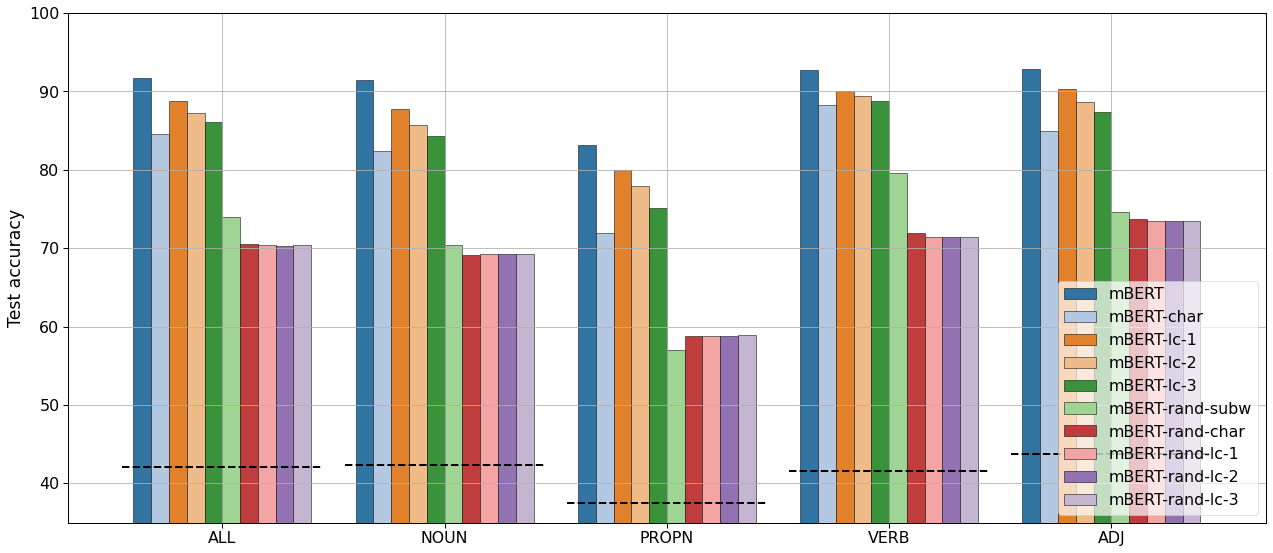

In [16]:
model_order = ['mBERT'] + model_perturbations
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(18, 8), facecolor='w')
    sns.barplot(x=b.pos, y=b.test_acc, hue=b.model, hue_order=model_order, 
                palette='tab20',
                ci=None,
                edgecolor='black', linewidth=.5, ax=ax)
    ax.set_ylim(35, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Test accuracy")
    ax.grid(True)
    ax.legend(title="", loc='lower right', framealpha=0.7, fancybox=True)
    
    for pi, p in enumerate(pos_order):
        yval = majority.loc[p]
        ax.plot((pi-0.45, pi+0.45), (yval, yval), linestyle='dashed', linewidth=2, color='black')
        
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/bar_bert_lc.pdf", dpi=600)

# Results


## Tokenization

### mBERT-rand

In [17]:
def get_diff(lc1, lc2, lc3, s, c):
    lc = max([lc1, lc2, lc3])
    m = max([s, c])
    return m - lc
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    (exps.perturbation.isin(('mBERT-rand-subw', 'mBERT-rand-lc-1', 'mBERT-rand-lc-2', 'mBERT-rand-lc-3', 
                             'mBERT-rand-char')))
].groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = 'lc_diff'
df["lc_diff"] = df.apply(lambda x : get_diff(x['mBERT-rand-lc-1'], x['mBERT-rand-lc-2'], x['mBERT-rand-lc-3'],
                                             x['mBERT-rand-subw'], x['mBERT-rand-char']), axis=1)

In [18]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Afrikaans            -2.700000
Hindi                -1.025000
Norwegian_Nynorsk    -0.566631
Albanian             -0.471429
German               -0.399955
Urdu                 -0.262500
English              -0.200000
Danish               -0.028358
Norwegian_Bokmal      0.038273
Lithuanian            0.049755
Swedish               0.343750
Portuguese            0.425000
Dutch                 0.464801
Serbian               1.176119
Slovak                1.289089
Russian               2.384535
Ukrainian             2.569232
Romanian              2.957264
Polish                3.076398
Croatian              3.460132
French                4.080285
Arabic                4.116459
Spanish               4.392857
Hebrew                4.443744
Catalan               4.458416
Persian               4.700000
Hungarian             4.866667
Bulgarian             5.407847
Czech                 5.853182
Latin                 6.212592
Armenian              6.516667
Slovenian             6.611573

In [19]:
df[df.lc_diff<0].language.describe()

count       110
unique       33
top       Czech
freq         13
Name: language, dtype: object

In [20]:
df[df.lc_diff<0].sort_values("lc_diff").reset_index()

perturbation,index,pos,language,task,mBERT-rand-char,mBERT-rand-lc-1,mBERT-rand-lc-2,mBERT-rand-lc-3,mBERT-rand-subw,lc_diff
0,256,verb,Latin,mood_verb,65.250000,69.150000,67.500000,71.250000,63.750000,-6.000000
1,64,adj,Slovenian,gender_adj,55.721393,60.149254,57.661692,57.114428,51.492537,-4.427861
2,192,propn,Russian,case_propn,56.666667,59.803922,60.539216,58.578431,51.470588,-3.872549
3,243,verb,German,verbform_verb,66.766169,70.149254,70.497512,68.358209,62.985075,-3.731343
4,175,propn,Czech,animacy_propn,66.550000,69.750000,67.850000,70.100000,63.600000,-3.550000
...,...,...,...,...,...,...,...,...,...,...
105,212,verb,Czech,animacy_verb,93.850000,93.850000,93.950000,93.650000,93.250000,-0.100000
106,142,noun,Portuguese,number_noun,97.900000,97.850000,97.800000,98.000000,84.850000,-0.100000
107,69,adj,Swedish,number_adj,81.750000,81.700000,80.650000,81.850000,74.050000,-0.100000
108,114,noun,Hebrew,gender_noun,93.950000,94.000000,94.000000,93.950000,82.050000,-0.050000


In [21]:
df[df.language == 'English']

perturbation,pos,language,task,mBERT-rand-char,mBERT-rand-lc-1,mBERT-rand-lc-2,mBERT-rand-lc-3,mBERT-rand-subw,lc_diff
100,noun,English,number_noun,97.25,96.65,97.50,97.50,80.75,-0.25
222,verb,English,tense_verb,94.15,95.65,94.15,94.45,80.65,-1.50
223,verb,English,verbform_verb,75.85,74.70,74.65,73.10,58.15,1.15


### mBERT

In [22]:
def get_diff(lc1, lc2, lc3, s, c):
    lc = max([lc1, lc2, lc3])
    m = max([s, c])
    return m - lc

df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation=='mBERT-lc-3') | (exps.perturbation=='mBERT-lc-2') | (exps.perturbation=='mBERT-lc-1') 
     | (exps.perturbation.isnull()) | (exps.perturbation=='mBERT-char'))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = 'lc_diff'
df["lc_diff"] = df.apply(lambda x : get_diff(x['mBERT-lc-1'], x['mBERT-lc-2'], x['mBERT-lc-3'], 
                                             x['mBERT'], x['mBERT-char']), axis=1)

In [23]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Romanian             0.045100
Albanian             0.364286
Spanish              0.792857
Catalan              0.837500
Armenian             1.133333
Bulgarian            1.414021
Slovak               1.415978
Urdu                 1.450000
Arabic               1.512604
Latvian              1.773601
Hungarian            1.783333
Swedish              1.893750
Estonian             1.905298
Portuguese           2.062500
Latin                2.242435
Lithuanian           2.563235
Italian              2.568750
Czech                2.626002
Afrikaans            2.650000
Polish               2.713844
Serbian              2.849046
Croatian             2.911606
Turkish              2.988676
Norwegian_Bokmal     3.168586
French               3.214905
Russian              3.215596
Danish               3.252438
Hebrew               3.678719
Slovenian            3.905226
Norwegian_Nynorsk    3.925835
English              4.050000
Ukrainian            4.113503
Basque               4.225598
G

In [24]:
df[df.lc_diff<0].language.describe()

count        53
unique       25
top       Czech
freq          5
Name: language, dtype: object

In [25]:
df[df.lc_diff<0].sort_values("lc_diff").reset_index()

perturbation,index,pos,language,task,mBERT,mBERT-char,mBERT-lc-1,mBERT-lc-2,mBERT-lc-3,lc_diff
0,56,adj,Russian,gender_adj,91.243781,85.572139,95.024876,90.696517,91.691542,-3.781095
1,303,verb,Slovenian,aspect_verb,76.800000,65.100000,80.450000,76.700000,74.100000,-3.650000
2,71,adj,Ukrainian,gender_adj,87.910448,87.363184,89.651741,89.552239,91.094527,-3.184080
3,187,propn,Latvian,gender_propn,89.750000,87.350000,91.700000,91.450000,87.450000,-1.950000
4,299,verb,Slovak,gender_verb,86.450000,85.350000,88.300000,88.150000,86.700000,-1.850000
5,174,propn,Albanian,gender_propn,81.600000,81.350000,83.350000,82.950000,81.900000,-1.750000
6,275,verb,Polish,aspect_verb,78.550000,72.050000,80.300000,78.150000,75.450000,-1.750000
7,115,noun,Hebrew,number_noun,96.950000,97.050000,95.000000,98.750000,95.450000,-1.700000
8,310,verb,Swedish,voice_verb,94.800000,96.600000,98.150000,97.150000,97.450000,-1.550000
9,180,propn,Dutch,gender_propn,68.900000,63.150000,69.250000,70.350000,66.850000,-1.450000
